# Proyecto: Retina vessel segmentation

La segmentación de los vasos sanguineos de la retina del fondo del ojo es una tarea importante en el diagnóstico de enfermedades como la diabetes y la hipertension.

La meta del proyecto es desarrollar un algoritmo que permita segmentar los vasos sanguineos de la retina del fondo del ojo.



![](https://dlsi.ua.es/~pertusa/tvainput21.png)
![](https://dlsi.ua.es/~pertusa/tvagt21.png)

In [117]:
import os
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
db_path = "TVAProject"

In [118]:
def plotter(img):
    plt.imshow(img, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

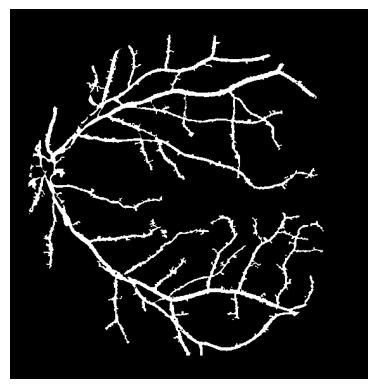

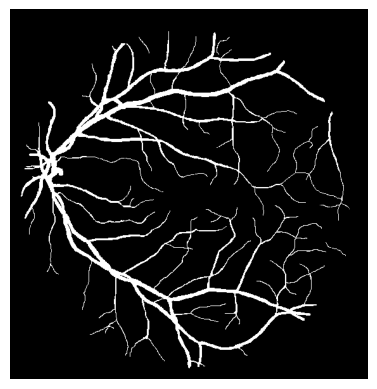

True

In [119]:
def preprocess(image):
    # Convertir a modalidad LAB
    lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
    l, a, b = cv.split(lab)
    
    ##plotter(l)

    # Se aplica Ecualización Adaptativa de Histograma con Limitación de Contraste
    clahe = cv.createCLAHE(clipLimit=3.0)
    cl = clahe.apply(l)
    limg = cv.merge((cl, a, b))

    ##plotter(limg)

    # Convertir de nuevo la modalidad LAB a RGB
    final = cv.cvtColor(limg, cv.COLOR_LAB2BGR)
            
    # Extraer canal verde
    _, green, _ = cv.split(final)
        
    windows = [(3,3), (5,5), (7,7), (9,9), (11,11)]
        
    morphed = green.copy()
    
    ##plotter(morphed)
        
    # Aplicar operaciones morfológicas con diferentes tamaños de ventana
    for window in windows:
        morphed = cv.morphologyEx(morphed, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, window), iterations = 1)
        morphed = cv.morphologyEx(morphed, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, window), iterations = 1)
        
    # Restar la imagen original del resultado de las operaciones morfológicas
    imgSubstracted = cv.subtract(morphed, green)
    imgSubstracted = clahe.apply(imgSubstracted)
    
    ##plotter(imgSubstracted)
        
    return imgSubstracted

def features(image):
    # Eliminación de contornos muy pequeños mediante umbralización para reducir el ruido
    ret, f6 = cv.threshold(image, 15, 255, cv.THRESH_BINARY)
    
    #plotter(f6)

    # Creación de una máscara para aplicar sobre la imagen
    mask = np.ones(image.shape[:2], dtype='uint8') * 255
    # Encontrar contornos en la imagen
    contours, hierarchy = cv.findContours(f6.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Eliminar contornos pequeños de la máscara
    for cnt in contours:
        if cv.contourArea(cnt) <= 255:
            cv.drawContours(mask, [cnt], -1, 0, -1)

    # Aplicar la máscara a la imagen
    im = cv.bitwise_and(image, image, mask=mask)
    #plotter(im)
    
    # Invertir la imagen después de aplicar la máscara
    _, fin = cv.threshold(im, 15, 255, cv.THRESH_BINARY_INV)
    #plotter(fin)
    
    
    # Erosionar la imagen para reducir aún más el ruido
    newfin = cv.erode(fin, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3)), iterations=1)
    #plotter(newfin)
    

    # Eliminar manchas (blobs) de tamaño no deseado
    fundus_eroded = cv.bitwise_not(newfin)
    xmask = np.ones(fundus_eroded.shape[:2], dtype='uint8') * 255
    xcontours, xhierarchy = cv.findContours(fundus_eroded.copy(), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    #plotter(fundus_eroded)
    
    # Clasificar y eliminar contornos basados en su forma y tamaño
    for cnt in xcontours:
        shape = 'unidentified'
        peri = cv.arcLength(cnt, True)
        approx = cv.approxPolyDP(cnt, 0.04 * peri, False)
        if len(approx) > 4 and cv.contourArea(cnt) <= 3000 and cv.contourArea(cnt) >= 100:
            shape = 'circle'
        else:
            shape = 'vessels'
            
        if(shape == 'circle'):
            cv.drawContours(xmask, [cnt], -1, 0, -1)

    # Aplicar la máscara final a la imagen
    finimage = cv.bitwise_and(fundus_eroded, fundus_eroded, mask=xmask)
    
    # Invertir la imagen final para resaltar los vasos sanguíneos
    blood_vessels = cv.bitwise_not(finimage)
    #plotter(blood_vessels)
    
    # Restar los vasos sanguíneos de un fondo blanco para mejorar el contraste
    blood_vessels = cv.subtract(255, blood_vessels)
    new1 = blood_vessels
    
    #plotter(new1)

    # Crear una máscara de ceros del mismo tamaño que la imagen original
    mask = np.zeros_like(new1)

    # Obtener el centro de la imagen
    height, width = new1.shape[:2]
    center = (width//2, height//2)

    # Dibujar un círculo en la máscara en el centro de la imagen
    cv.circle(mask, center, 255, (255,255,255), -1)
    #plotter(mask)

    # Sustraer la máscara de la imagen original para posiblemente centrar los vasos sanguíneos
    result = cv.bitwise_and(new1, mask)
    #plotter(result)

    # Erosionar la imagen para eliminar objetos más pequeños
    kernel = np.ones((2,2), np.uint8)
    result = cv.erode(result, kernel, iterations=1)
    #plotter(result)
    
    return result


def vessel_segmentation(input_image):
    # Step1: Read the retinal image
    retinal_image = cv.imread(input_image, cv.IMREAD_COLOR)
    # Step2: Abstract the green channel of the input image
    green = preprocess(retinal_image)
    img = features(green)
    return img


# Apply the vessel segmentation function to the uploaded image
input_image_path = 'TVAProject/input/21.png'
segmented_image_result = vessel_segmentation(input_image_path)

# Plot the results
plt.imshow(segmented_image_result, cmap='gray')
#dont show the axis
plt.axis('off')
plt.show()


# Plot the results
img = cv.imread('TVAProject/gt/21.png', cv.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
#dont show the axis
plt.axis('off')
plt.show()

# Save the results
output_image_path = 'save.png'
cv.imwrite(output_image_path, segmented_image_result)

In [120]:
def single_IoU(img_name):

    # Apply segmentation
    input_img = os.path.join(db_path, 'input', img_name)
    obtained = vessel_segmentation(input_img)

    # Path of the target (ground truth) image
    path_target = os.path.join(db_path, 'gt', img_name)
    solution = cv.imread(path_target, cv.IMREAD_GRAYSCALE)

    # Show obtained results
    plt.imshow(obtained, cmap=plt.get_cmap('gray'))
    plt.show()

    # IoU calculation
    intersectionAB = cv.countNonZero(obtained & solution)
    unionAB = cv.countNonZero(obtained | solution)
    score = intersectionAB / unionAB
    print("Image {} - IoU={}".format(path_input, score))

    return score



['28.png', '29.png', '39.png', '38.png', '35.png', '21.png', '34.png', '22.png', '36.png', '37.png', '23.png', '27.png', '33.png', '32.png', '26.png', '30.png', '24.png', '25.png', '31.png', '40.png']


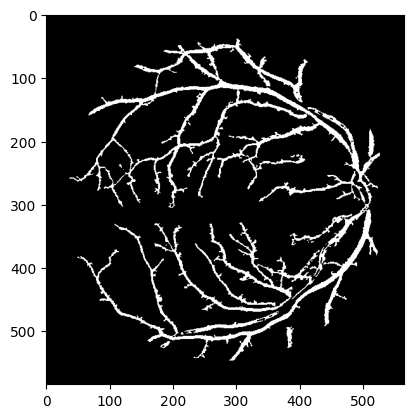

Image TVAProject/input - IoU=0.5086641807413906


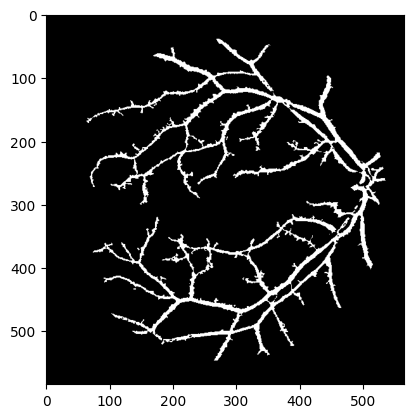

Image TVAProject/input - IoU=0.5212373823295906


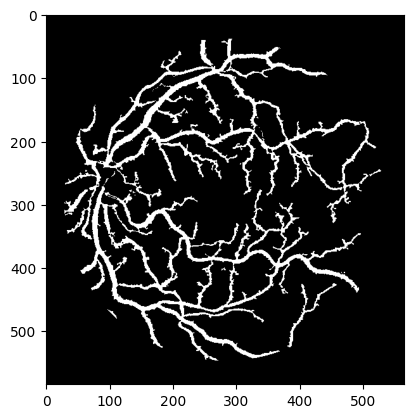

Image TVAProject/input - IoU=0.5020258631147342


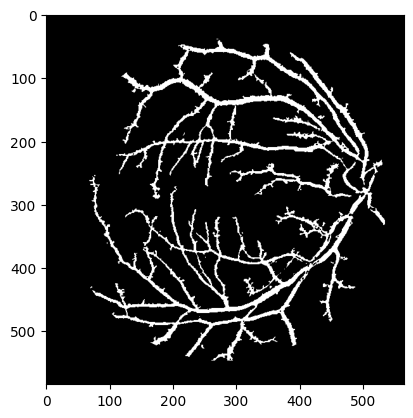

Image TVAProject/input - IoU=0.4989712699238988


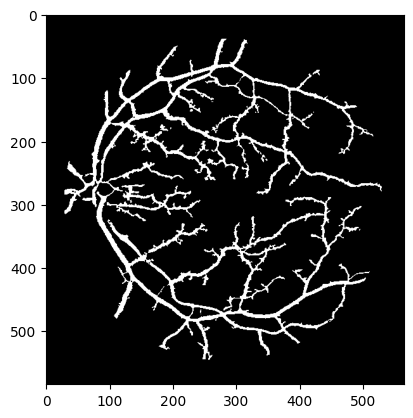

Image TVAProject/input - IoU=0.5157541725159881


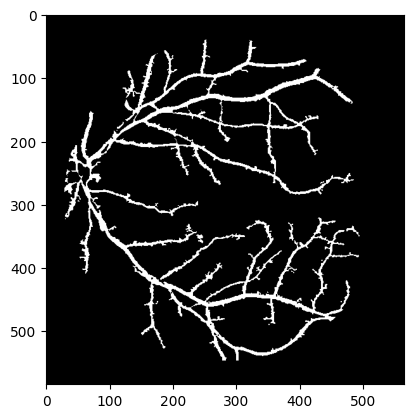

Image TVAProject/input - IoU=0.5079602585587742


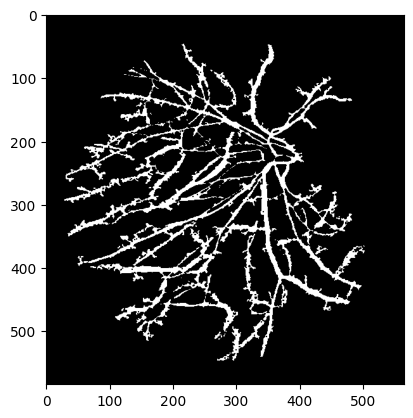

Image TVAProject/input - IoU=0.39540464960974997


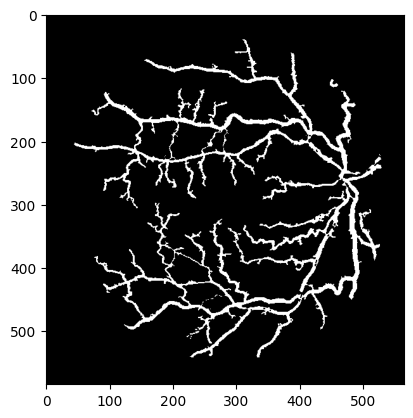

Image TVAProject/input - IoU=0.5358814141578079


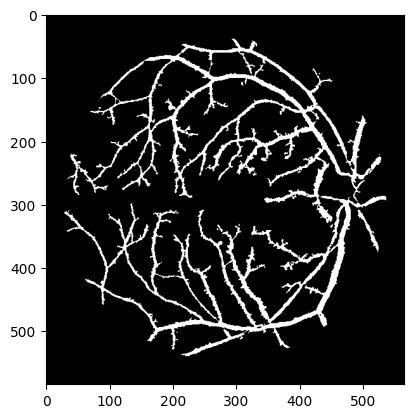

Image TVAProject/input - IoU=0.5003359122727175


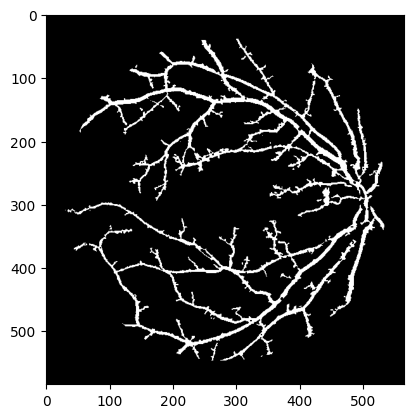

Image TVAProject/input - IoU=0.5205869062491694


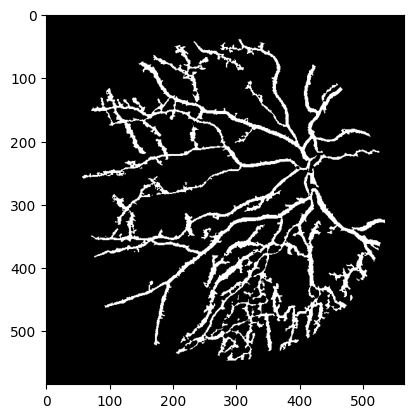

Image TVAProject/input - IoU=0.36971384531238344


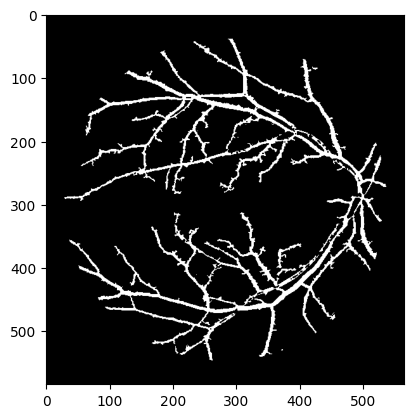

Image TVAProject/input - IoU=0.5157036029911625


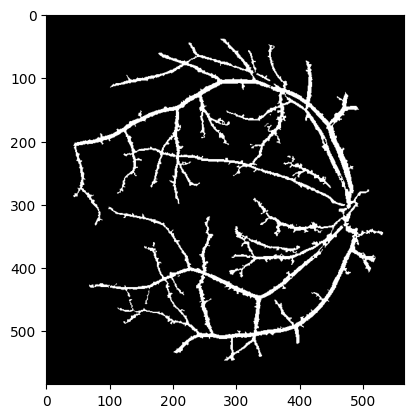

Image TVAProject/input - IoU=0.5282167675409101


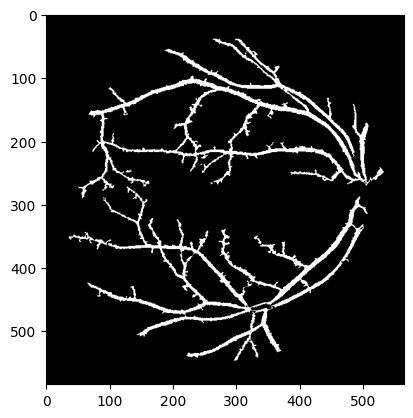

Image TVAProject/input - IoU=0.4983545571612534


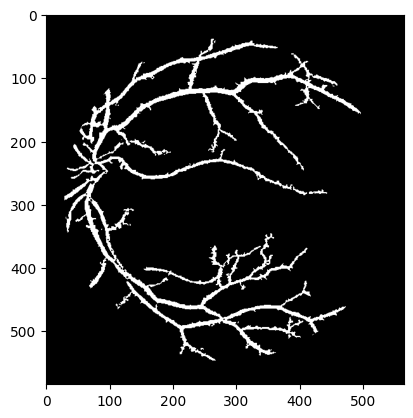

Image TVAProject/input - IoU=0.5469256635042632


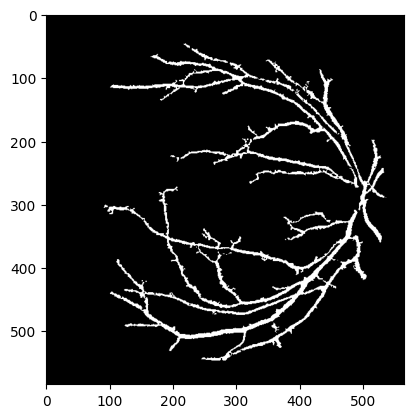

Image TVAProject/input - IoU=0.4871611316878832


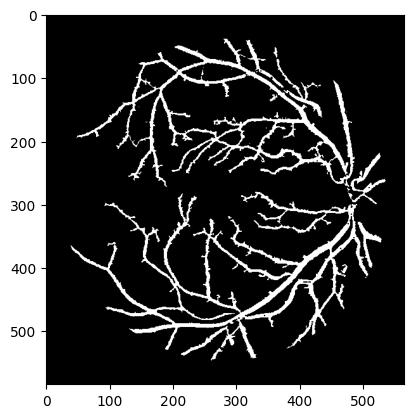

Image TVAProject/input - IoU=0.5493482719834145


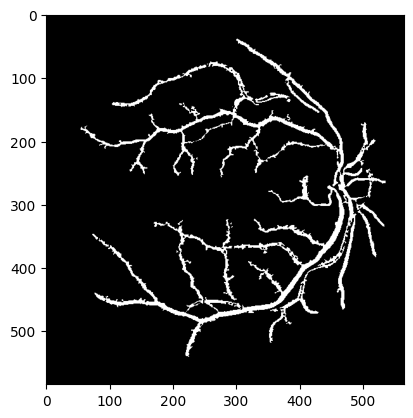

Image TVAProject/input - IoU=0.47441133740851404


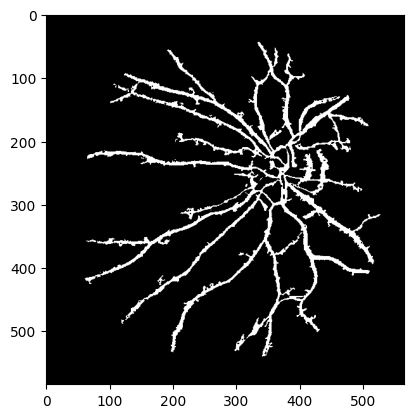

Image TVAProject/input - IoU=0.4777460723539637


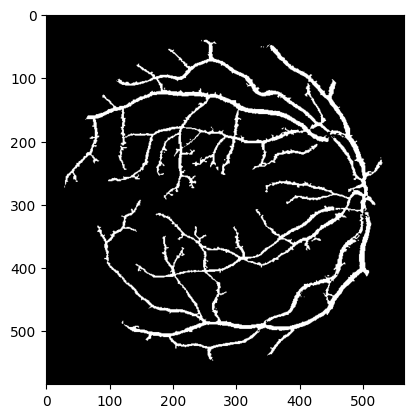

Image TVAProject/input - IoU=0.49368135786621026
------------------------------------
Mean IoU=0.49740423086418895


In [121]:
meanIoU=0

path_input = os.path.join(db_path, 'input')

# List images in input folder
imgs = [f for f in os.listdir(path_input) if f.endswith('.png')]
print(imgs)

# Calculate IoU for each image and get meanIoU
for img in imgs:
    meanIoU += single_IoU(img)

# Average
meanIoU /= len(imgs)
print("------------------------------------")
print("Mean IoU={}".format(meanIoU))
